In [1]:
from gpytorch.kernels import Kernel

class RBFKernel(Kernel):
    r"""
    Computes a covariance matrix based on the RBF (squared exponential) kernel
    between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:

    .. math::

       \begin{equation*}
          k_{\text{RBF}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left( -\frac{1}{2}
          (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-2} (\mathbf{x_1} - \mathbf{x_2}) \right)
       \end{equation*}

    where :math:`\Theta` is a :attr:`lengthscale` parameter.
    See :class:`gpytorch.kernels.Kernel` for descriptions of the lengthscale options.

    .. note::

        This kernel does not have an `outputscale` parameter. To add a scaling parameter,
        decorate this kernel with a :class:`gpytorch.kernels.ScaleKernel`.

    Args:
        :attr:`ard_num_dims` (int, optional):
            Set this if you want a separate lengthscale for each
            input dimension. It should be `d` if :attr:`x1` is a `n x d` matrix. Default: `None`
        :attr:`batch_shape` (torch.Size, optional):
            Set this if you want a separate lengthscale for each
            batch of input data. It should be `b` if :attr:`x1` is a `b x n x d` tensor. Default: `torch.Size([])`.
        :attr:`active_dims` (tuple of ints, optional):
            Set this if you want to compute the covariance of only a few input dimensions. The ints
            corresponds to the indices of the dimensions. Default: `None`.
        :attr:`lengthscale_prior` (Prior, optional):
            Set this if you want to apply a prior to the lengthscale parameter.  Default: `None`.
        :attr:`lengthscale_constraint` (Constraint, optional):
            Set this if you want to apply a constraint to the lengthscale parameter. Default: `Positive`.
        :attr:`eps` (float):
            The minimum value that the lengthscale can take (prevents divide by zero errors). Default: `1e-6`.

    Attributes:
        :attr:`lengthscale` (Tensor):
            The lengthscale parameter. Size/shape of parameter depends on the
            :attr:`ard_num_dims` and :attr:`batch_shape` arguments.

    Example:
        >>> x = torch.randn(10, 5)
        >>> # Non-batch: Simple option
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        >>> # Non-batch: ARD (different lengthscale for each input dimension)
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=5))
        >>> covar = covar_module(x)  # Output: LazyTensor of size (10 x 10)
        >>>
        >>> batch_x = torch.randn(2, 10, 5)
        >>> # Batch: Simple option
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        >>> # Batch: different lengthscale for each batch
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([2])))
        >>> covar = covar_module(x)  # Output: LazyTensor of size (2 x 10 x 10)
    """

    has_lengthscale = True

    def forward(self, x1, x2, diag=False, **params):
        if (
            x1.requires_grad
            or x2.requires_grad
            or (self.ard_num_dims is not None and self.ard_num_dims > 1)
            or diag
            or trace_mode.on()
        ):
            x1_ = x1.div(self.lengthscale)
            x2_ = x2.div(self.lengthscale)
            return self.covar_dist(
                x1_, x2_, square_dist=True, diag=diag, dist_postprocess_func=postprocess_rbf, postprocess=True, **params
            )
        return RBFCovariance().apply(
            x1,
            x2,
            self.lengthscale,
            lambda x1, x2: self.covar_dist(
                x1, x2, square_dist=True, diag=False, dist_postprocess_func=postprocess_rbf, postprocess=False, **params
            ),
        )

        

In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

train_x = torch.linspace(0, 1, 10)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi))).add(1).div(2)

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 0.909
Iter 2/50 - Loss: 5.393
Iter 3/50 - Loss: 8.490
Iter 4/50 - Loss: 3.704
Iter 5/50 - Loss: 6.667
Iter 6/50 - Loss: 6.993
Iter 7/50 - Loss: 6.304
Iter 8/50 - Loss: 4.980
Iter 9/50 - Loss: 3.934
Iter 10/50 - Loss: 3.233
Iter 11/50 - Loss: 2.854
Iter 12/50 - Loss: 2.644
Iter 13/50 - Loss: 2.402
Iter 14/50 - Loss: 2.211
Iter 15/50 - Loss: 1.929
Iter 16/50 - Loss: 1.667
Iter 17/50 - Loss: 1.545
Iter 18/50 - Loss: 1.505
Iter 19/50 - Loss: 1.475
Iter 20/50 - Loss: 1.453
Iter 21/50 - Loss: 1.444
Iter 22/50 - Loss: 1.442
Iter 23/50 - Loss: 1.438
Iter 24/50 - Loss: 1.428
Iter 25/50 - Loss: 1.412
Iter 26/50 - Loss: 1.390
Iter 27/50 - Loss: 1.365
Iter 28/50 - Loss: 1.335
Iter 29/50 - Loss: 1.304
Iter 30/50 - Loss: 1.271
Iter 31/50 - Loss: 1.239
Iter 32/50 - Loss: 1.207
Iter 33/50 - Loss: 1.178
Iter 34/50 - Loss: 1.151
Iter 35/50 - Loss: 1.128
Iter 36/50 - Loss: 1.109
Iter 37/50 - Loss: 1.093
Iter 38/50 - Loss: 1.078
Iter 39/50 - Loss: 1.064
Iter 40/50 - Loss: 1.048
Iter 41/5

In [3]:
import torch
from gpytorch.functions import RBFCovariance
from gpytorch.settings import trace_mode
from gpytorch.kernels import Kernel


def postprocess_rbf(dist_mat):
    return dist_mat.div_(-2).exp_()


class RBF21Kernel(Kernel):
    r"""
    Computes a covariance matrix based on the RBF (squared exponential) kernel
    between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:

    .. math::

       \begin{equation*}
          k_{\text{RBF}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left( -\frac{1}{2}
          (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-2} (\mathbf{x_1} - \mathbf{x_2}) \right)
       \end{equation*}

    where :math:`\Theta` is a :attr:`lengthscale` parameter.
    See :class:`gpytorch.kernels.Kernel` for descriptions of the lengthscale options.

    .. note::

        This kernel does not have an `outputscale` parameter. To add a scaling parameter,
        decorate this kernel with a :class:`gpytorch.kernels.ScaleKernel`.

    Args:
        :attr:`ard_num_dims` (int, optional):
            Set this if you want a separate lengthscale for each
            input dimension. It should be `d` if :attr:`x1` is a `n x d` matrix. Default: `None`
        :attr:`batch_shape` (torch.Size, optional):
            Set this if you want a separate lengthscale for each
            batch of input data. It should be `b` if :attr:`x1` is a `b x n x d` tensor. Default: `torch.Size([])`.
        :attr:`active_dims` (tuple of ints, optional):
            Set this if you want to compute the covariance of only a few input dimensions. The ints
            corresponds to the indices of the dimensions. Default: `None`.
        :attr:`lengthscale_prior` (Prior, optional):
            Set this if you want to apply a prior to the lengthscale parameter.  Default: `None`.
        :attr:`lengthscale_constraint` (Constraint, optional):
            Set this if you want to apply a constraint to the lengthscale parameter. Default: `Positive`.
        :attr:`eps` (float):
            The minimum value that the lengthscale can take (prevents divide by zero errors). Default: `1e-6`.

    Attributes:
        :attr:`lengthscale` (Tensor):
            The lengthscale parameter. Size/shape of parameter depends on the
            :attr:`ard_num_dims` and :attr:`batch_shape` arguments.

    Example:
        >>> x = torch.randn(10, 5)
        >>> # Non-batch: Simple option
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        >>> # Non-batch: ARD (different lengthscale for each input dimension)
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=5))
        >>> covar = covar_module(x)  # Output: LazyTensor of size (10 x 10)
        >>>
        >>> batch_x = torch.randn(2, 10, 5)
        >>> # Batch: Simple option
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        >>> # Batch: different lengthscale for each batch
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([2])))
        >>> covar = covar_module(x)  # Output: LazyTensor of size (2 x 10 x 10)
    """

    has_lengthscale = True

    def forward(self, x1, x2, diag=False, **params):
        print(torch.equal(x1,x2))
        Answer=self.covar_dist(x1, x2, square_dist=True, diag=diag, postprocess=False, **params)
        print(Answer)
        return Answer
        
x=[[1.,2.,3.],[4.,5.,6.]]
x1=torch.tensor(x)
x2=torch.ones(x1.size(0),x1.size(1))
x1_norm = x1.pow(2).sum(dim=-1, keepdim=True)
adjustment = x1.mean(-2, keepdim=True)
x1=x1-adjustment
print(x1.size(1))
x3=x2.t()
print(x3)


3
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])


Iter 1/50 - Loss: 1.001
Iter 2/50 - Loss: 6.428
Iter 3/50 - Loss: 4.856
Iter 4/50 - Loss: 3.246
Iter 5/50 - Loss: 2.627
Iter 6/50 - Loss: 1.987
Iter 7/50 - Loss: 1.686
Iter 8/50 - Loss: 1.604
Iter 9/50 - Loss: 1.609
Iter 10/50 - Loss: 1.645
Iter 11/50 - Loss: 1.676
Iter 12/50 - Loss: 1.696
Iter 13/50 - Loss: 1.705
Iter 14/50 - Loss: 1.705
Iter 15/50 - Loss: 1.698
Iter 16/50 - Loss: 1.687
Iter 17/50 - Loss: 1.672
Iter 18/50 - Loss: 1.656
Iter 19/50 - Loss: 1.638
Iter 20/50 - Loss: 1.618
Iter 21/50 - Loss: 1.596
Iter 22/50 - Loss: 1.572
Iter 23/50 - Loss: 1.545
Iter 24/50 - Loss: 1.516
Iter 25/50 - Loss: 1.486
Iter 26/50 - Loss: 1.454
Iter 27/50 - Loss: 1.423
Iter 28/50 - Loss: 1.391
Iter 29/50 - Loss: 1.360
Iter 30/50 - Loss: 1.329
Iter 31/50 - Loss: 1.299
Iter 32/50 - Loss: 1.269
Iter 33/50 - Loss: 1.239
Iter 34/50 - Loss: 1.209
Iter 35/50 - Loss: 1.180
Iter 36/50 - Loss: 1.151
Iter 37/50 - Loss: 1.123
Iter 38/50 - Loss: 1.096
Iter 39/50 - Loss: 1.071
Iter 40/50 - Loss: 1.047
Iter 41/5

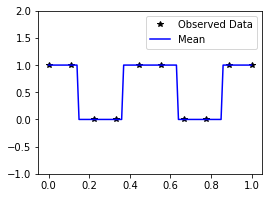

In [6]:
import torch
from gpytorch.functions import RBFCovariance
from gpytorch.settings import trace_mode
from gpytorch.kernels import Kernel


def postprocess_rbf(dist_mat):
    return dist_mat.div_(-2).exp_()

class RBF1Kernel(Kernel):
    
    has_lengthscale = True
    
    def __init__(
        self,
        dims,
        rank,
    ):
        super(RBF1Kernel, self).__init__()
        self.register_parameter(
            name="linear_projection",
            parameter=torch.nn.Parameter(torch.randn(rank,dims)),
        )

    def forward(self, x1, x2, diag=False, **params):
        #print(self.linear_projection.size())
        x1raw=x1
        #print(x1raw.size())
        #print(self.linear_projection)
        P1raw=self.linear_projection.mm(x1raw.t())
        #print(P1raw.size())
        pt1=P1raw.t()
        #print(pt1.size())
        pt1_=pt1.div(self.lengthscale)
        x2raw=x2
        P2raw=self.linear_projection.mm(x2raw.t())
        pt2=P2raw.t()
        pt2_=pt2.div(self.lengthscale)
        return self.covar_dist(
                pt1_, pt2_, square_dist=True, diag=False, dist_postprocess_func=postprocess_rbf, postprocess=True, **params
        )
    def getfull(self):
        pleft=self.linear_projection.t()
        Covarfull=pleft.mm(self.linear_projection)
        return(Covarfull)
        
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

train_x = torch.linspace(0, 1, 10)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi))).add(1).div(2)

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = RBF1Kernel(rank=5,dims=1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()
    
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean'])

In [5]:
import torch
test_x = torch.linspace(0, 1, 101)
print(test_x.dim())
print(test_x)
test_x=test_x.unsqueeze(-1)
print(test_x)

1
tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000])
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
   

In [1]:
#加入*的交叉验证版本
import xlrd
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#操作feature向量的类
class Creat1():
    def get_1(self, base):
        self.base=base
        self.num=1
    def get_2(self, base1, base2):
        self.base1=base1
        self.base2=base2
        self.num=2
    def abs_ad(self):
        self.ans=[]
        if self.num==1:
            for i in range(len(self.base)-1):
                for j in self.base[i+1:]:
                    self.tem=abs(self.base[i]+j)
                    self.ans.append(self.tem)
        else:
            for i in self.base1:
                for j in self.base2:
                    self.tem=abs(i+j)
                    self.ans.append(self.tem)
        return self.ans
    def abs_sb(self):
        self.ans=[]
        if self.num==1:
            for i in range(len(self.base)-1):
                for j in self.base[i+1:]:
                    self.tem=abs(self.base[i]-j)
                    self.ans.append(self.tem)
        else:
            for i in self.base1:
                for j in self.base2:
                    self.tem=abs(i-j)
                    self.ans.append(self.tem)
        return self.ans
    def square(self):
        self.ans=[]
        for i in range(len(self.base)):
            self.tem=self.base[i]**2
            self.ans.append(self.tem)
        return self.ans
    def expon(self):
        self.ans=[]
        for i in self.base:
            self.tem=np.exp(i)
            self.ans.append(self.tem)
        return self.ans
    def ratio(self):
        self.ans=[]
        if self.num==1:
            for i in range(len(self.base)):
                for j in range(len(self.base)):
                    if(i!=j):
                        self.tem=self.base[i]/self.base[j]
                        self.ans.append(self.tem)
        if self.num==2:
            for i in self.base1:
                for j in self.base2:
                    self.tem=i/j
                    self.ans.append(self.tem)
        return self.ans
Dpt=[]

ele0=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe',
     'Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb',
     'Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os',
     'Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm','Md',
     'No','Lr']
elene=[2.20,1000,0.98,1.57,2.04,2.55,3.04,3.44,3.98,1000,0.93,1.31,1.61,1.90,2.19,2.58,3.16,1000,0.82,1.00,1.36,1.54,1.63,1.66,
      1.55,1.83,1.88,1.91,1.90,1.65,1.81,2.01,2.18,2.55,2.96,3.00,0.82,0.95,1.22,1.33,1.6,2.16,1.9,2.2,2.28,2.2,1.93,1.69,1.78,
      1.96,2.05,2.1,2.66,2.60,0.79,0.89,1.1,1.12,1.13,1.14,1.13,1.17,1.2,1.2,1.1,1.22,1.23,1.24,1.25,1.1,1.27,1.3,1.5,2.36,1.9,
      2.2,2.20,2.28,2.54,2.0,1.62,1.87,2.02,2.0,2.2,2.2,0.795,0.9,1.1,1.3,1.5,1.38,1.36,1.28,1.13,1.28,1.3,1.3,1.3,1.3,1.3,1.3,1.3]
elena=[72.769,-48.2,59.633,-48.2,26.989,121.776,-6.8,140.976,328.165,-116.19,52.867,-40.19,41.763,134.068,72.037,200.410,348.575,
      -96.2,48.383,2.37,18.2,7.289,50.911,65.21,-50.2,14.785,63.898,111.65,119.235,-58.2,29.061,118.935,77.65,194.959,324.537,-96.2,
      46.884,5.023,29.6,41.807,88.517,72.1,53.2,100.96,110.27,54.24,125.862,-68.2,37.043,107.298,101.059,190.161,295.153,-77.2,45.505,
      13.954,53.795,55.2,10.539,9.406,12.45,15.63,11.2,13.22,12.670,33.96,32.61,30.10,99.3,-1.93,23.04,17.18,31.2,78.76,5.8273,103.99,
      150.94,205.041,222.747,-48.2,36.414,34.4183,90.924,136.7,223.12,-68.2,46.89,9.6485,33.77,112.72,53.03,50.94,45.85,-48.33,9.93,
      27.17,-165.24,-97.31,-28.6,33.96,93.91,-223.22,-30.04]
rcov=[31.5,28,128.7,96.3,84.3,76.1,71.1,66.2,57.3,58,166.9,141.7,121.4,111.2,107.3,105.3,102.4,106.1,203.1,176.1,170.7,160.8,153.8,
     139.5,139.5,132.3,126.3,124.4,132.4,122.4,122.3,120.4,119.4,120.4,120.3,116.4,220.9,195.1,190.7,175.7,164.6,154.5,147.7,146.7,
     142.7,139.6,145.5,144.9,142.5,139.4,139.5,138.4,139.3,140.9,244.1,215.1,207.8,204.9,203.7,201.6,199,198.8,198.6,196.6,194.5,
     192.7,192.7,189.6,190.1,187.8,175.1,187.8,170.8,162.7,151.7,144.4,141.6,136.5,136.6,132.5,145.7,146.5,148.4,140.4,150,150,260,
     221.2,215,206.6,200,196.7,190.1,187.1,180.6,169.3,166,168,165,167,173,176,161]
eleipabs=[13.60,24.59,5.392,9.323,8.298,11.26,14.53,13.62,17.42,21.56,5.139,7.646,5.986,8.152,10.49,10.36,12.97,15.76,4.341,6.113,6.562,
      6.828,6.746,6.767,7.434,7.902,7.881,7.640,7.726,9.394,5.999,7.899,9.789,9.752,11.81,14.00,4.177,5.695,6.217,6.634,6.759,7.092,
      7.280,7.361,7.459,8.337,7.576,8.994,5.786,7.344,8.608,9.010,10.45,12.13,3.894,5.212,5.577,5.539,5.473,5.525,5.582,5.644,5.670,
      6.150,5.864,5.939,6.022,6.108,6.184,6.254,5.426,6.825,7.550,7.864,7.834,8.438,8.967,8.959,9.226,10.44,6.108,7.417,7.286,8.417,
      9.318,10.75,4.073,5.278,5.17,6.307,5.89,6.194,6.266,6.026,5.974,5.992,6.198,6.282,6.42,6.50,6.58,6.65,4.9]
eleip=[]
for i in eleipabs:
    eleip.append(-i)
def getf(values,ways):
    if(ways=='max'):
        ans=values[0]
        for d in values:
            if(d>ans):
                ans=d
    if(ways=='min'):
        ans=values[0]
        for d in values:
            if(d<ans):
                ans=d
    if(ways=='mean'):
        sum=0
        for d in values:
            sum=sum+d
        ans=sum/len(values)
    return ans

#a,b,c晶格常数
data=pd.read_csv(r"C:\Users\ROG\Desktop\liveproject\latest\a.txt", header=None,index_col=False)
dfa=np.array(data,dtype=float)
alen=dfa.tolist()
adata=[]
for i in alen:
    adata.append(i[0])
datab=pd.read_csv(r"C:\Users\ROG\Desktop\liveproject\latest\b.txt", header=None,index_col=False)
dfb=np.array(datab,dtype=float)
blen=dfb.tolist()
bdata=[]
for i in blen:
    bdata.append(i[0])
datac=pd.read_csv(r"C:\Users\ROG\Desktop\liveproject\latest\c.txt", header=None,index_col=False)
dfc=np.array(datac,dtype=float)
clen=dfc.tolist()
cdata=[]
for i in clen:
    cdata.append(i[0])
    
excel=xlrd.open_workbook(r"C:\Users\ROG\Desktop\liveproject\latest\cifname.xls")

all_sheet=excel.sheets()

sheet1=all_sheet[0]
matname=sheet1.col_values(0)
dsq=sheet1.col_values(1)
dv=sheet1.col_values(2)
label=sheet1.col(4)
tip=0    #为了加入晶格常数
ttest=0  #区分验证组
ttrain=0 #区分训练组
Dpt=[]
Y=[]
Xtest=[]
Ytest=[]
Xtot=[]
Ytot=[]
tot=0
print(len(dv))
for i in matname:
    elements=[]
    for k in range(len(i)):
        if (ord(i[k])>64)&(ord(i[k])<91):
            ele=i[k]
            if(k<(len(i)-1)):
                if(ord(i[k+1])>96)&(ord(i[k+1])<123):
                    ele=ele+i[k+1]
            rep=0
            for j in elements:
                if(j==ele):
                    rep=1
            if(rep==0):
                elements.append(ele)
    ip=[]
    ea=[]
    en=[]
    rc=[]
    for j in elements:
        for k in range(len(ele0)):
            if(j==ele0[k]):
                ip.append(eleip[k])
                ea.append(elena[k])
                en.append(elene[k])
                rc.append(rcov[k])
    imax=getf(ip,'max')
    eamax=getf(ea,'max')
    enmax=getf(en,'max')
    A1=[eamax,enmax,imax]
    imin=getf(ip,'min')
    eamin=getf(ea,'min')
    enmin=getf(en,'min')
    A2=[eamin,enmin,imin]
    A3=[adata[tip],bdata[tip],cdata[tip],dsq[tip],dv[tip]]
    rmax=getf(rc,'max')
    rmin=getf(rc,'min')
    A4=[rmax,rmin]    
    print(A1)
    print(A2)
    print(A3)
    print(A4)
    Generation=[]
    creat=Creat1()
    #手动产生新特征
    creat.get_1(A1)
    Generation.append(creat.abs_ad()) #0
    creat.get_1(A2)
    Generation.append(creat.abs_ad()) #1
    creat.get_1(A3)
    Generation.append(creat.abs_ad()) #2
    creat.get_1(A4)
    Generation.append(creat.abs_ad()) #3
    creat.get_1(A1)
    Generation[0].extend(creat.abs_sb())
    creat.get_1(A2)
    Generation[1].extend(creat.abs_sb())
    creat.get_1(A3)
    Generation[2].extend(creat.abs_sb())
    creat.get_1(A4)
    Generation[3].extend(creat.abs_sb())
    creat.get_1(A1)
    Generation.append(creat.ratio()) #4
    creat.get_1(A2)
    Generation.append(creat.ratio()) #5
    creat.get_1(A3)
    Generation.append(creat.ratio()) #6
    creat.get_1(A4)
    Generation.append(creat.ratio()) #7
    creat.get_2(A1,A2)
    Generation.append(creat.ratio()) #8
    creat.get_2(A1,A3)
    Generation.append(creat.ratio()) #9
    creat.get_2(A1,A4)
    Generation.append(creat.ratio()) #10
    creat.get_2(A2,A3)
    Generation.append(creat.ratio()) #11
    creat.get_2(A2,A4)
    Generation.append(creat.ratio()) #12
    creat.get_2(A3,A4)
    Generation.append(creat.ratio()) #13
    print(A1)
    print(A2)
    print(A3)
    print(A4)
    #for i in Generation:
        #print(len(i))
    if (str(label[tip])=='number:3.0')or(str(label[tip])=='number:4.0')or(str(label[tip])=='text:\'yes*\'')or(str(label[tip])=='text:\'no*\''):
        Xtest.append([])
        Xtest[ttest].extend(A1)
        Xtest[ttest].extend(A2)
        Xtest[ttest].extend(A3)
        Xtest[ttest].extend(A4)
        Xtot.append([])
        Xtot[tot].extend(A1)
        Xtot[tot].extend(A2)
        Xtot[tot].extend(A3)
        Xtot[tot].extend(A4)
        for j in Generation:
            Xtest[ttest].extend(j)
            Xtot[tot].extend(j)
        if (str(label[tip])=='number:3.0')or(str(label[tip])=='text:\'no*\''):
            Ytest.append(0.0)
            Ytot.append(0.0)
        if (str(label[tip])=='number:4.0')or(str(label[tip])=='text:\'yes*\''):
            Ytest.append(1.0)
            Ytot.append(1.0)
        ttest=ttest+1 
        tot=tot+1
    if (str(label[tip])=='number:0.0')or(str(label[tip])=='number:1.0')or(str(label[tip])=='text:\'yes\'')or(str(label[tip])=='text:\'no\''):
        Dpt.append([])
        print(Dpt[ttrain])
        Dpt[ttrain].extend(A1)
        Dpt[ttrain].extend(A2)
        Dpt[ttrain].extend(A3)
        Dpt[ttrain].extend(A4)
        Xtot.append([])
        Xtot[tot].extend(A1)
        Xtot[tot].extend(A2)
        Xtot[tot].extend(A3)
        Xtot[tot].extend(A4)
        print("Here",len(Dpt[ttrain]))
        print(Dpt[ttrain])
        for j in Generation:
            Dpt[ttrain].extend(j)
            print(len(Dpt[ttrain]))
            Xtot[tot].extend(j)
        print(len(Dpt[ttrain]))
        if (str(label[tip])=='number:0.0')or(str(label[tip])=='text:\'no\''):
            Y.append(0.0)
            Ytot.append(0.0)
        if (str(label[tip])=='number:1.0')or(str(label[tip])=='text:\'yes\''):
            Y.append(1.0)
            Ytot.append(1.0)
        ttrain=ttrain+1
        tot=tot+1
    tip=tip+1
print(ttest)
print(ttrain)
print(len(Dpt),len(Y))
print(len(Xtest),len(Ytest))
print(len(Xtot),len(Ytot))
print(len(Dpt[0]))
for i in range(len(Dpt[0])):
    max1=0
    min1=0
    for j in range(len(Dpt)):
        if Dpt[j][i]>max1: 
            max1=Dpt[j][i]
        if Dpt[j][i]<min1:
            min1=Dpt[j][i]
    ruler=max1-min1
    #for j in range(len(Dpt)):
        #nvariance=nvariance+(Dpt[j][i]-mean)*(Dpt[j][i]-mean)
    #variance=nvariance/float(len(Dpt))
    for j in range(len(Dpt)):
        #Dpt[j][i]=Dpt[j][i]-mean
        #Dpt[j][i]=Dpt[j][i]/math.sqrt(variance)
        #Dpt[j][i]=Dpt[j][i]*math.sqrt(float(len(Dpt)))
        #Dpt[j][i]=Dpt[j][i]/1000.0
        Dpt[j][i]=Dpt[j][i]-min1
        Dpt[j][i]=Dpt[j][i]/ruler
        Dpt[j][i]=Dpt[j][i]/500.0
for i in range(len(Xtest[0])):
    max1=0
    min1=0
    for j in range(len(Xtest)):
        if Xtest[j][i]>max1:
            max1=Xtest[j][i]
        if Xtest[j][i]<min1:
            min1=Xtest[j][i]
    ruler=max1-min1
    for j in range(len(Xtest)):
        Xtest[j][i]=Xtest[j][i]-min1
        Xtest[j][i]=Xtest[j][i]/ruler
        Xtest[j][i]=Xtest[j][i]/500.0

for i in range(len(Xtot[0])):
    max1=0
    min1=0
    for j in range(len(Xtot)):
        if Xtot[j][i]>max1:
            max1=Xtot[j][i]
        if Xtot[j][i]<min1:
            min1=Xtot[j][i]
    ruler=max1-min1
    for j in range(len(Xtot)):
        Xtot[j][i]=Xtot[j][i]-min1
        Xtot[j][i]=Xtot[j][i]/ruler
        Xtot[j][i]=Xtot[j][i]/500.0

1017
[328.165, 3.98, -5.212]
[13.954, 0.89, -17.42]
[4.5032, 4.5032, 7.4354, 3.188, 2.665]
[215.1, 57.3]
[328.165, 3.98, -5.212]
[13.954, 0.89, -17.42]
[4.5032, 4.5032, 7.4354, 3.188, 2.665]
[215.1, 57.3]
[]
Here 13
[328.165, 3.98, -5.212, 13.954, 0.89, -17.42, 4.5032, 4.5032, 7.4354, 3.188, 2.665, 215.1, 57.3]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[348.575, 3.98, -6.113]
[2.37, 1.0, -17.42]
[3.8943, 3.8943, 6.8182, 2.753, 2.362]
[176.1, 57.3]
[348.575, 3.98, -6.113]
[2.37, 1.0, -17.42]
[3.8943, 3.8943, 6.8182, 2.753, 2.362]
[176.1, 57.3]
[]
Here 13
[348.575, 3.98, -6.113, 2.37, 1.0, -17.42, 3.8943, 3.8943, 6.8182, 2.753, 2.362, 176.1, 57.3]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[134.068, 1.9, -5.139]
[41.763, 0.93, -8.152]
[4.1259, 4.1259, 7.3744309999999995, 2.91745, 2.5829]
[166.9, 111.2]
[134.068, 1.9, -5.139]
[41.763, 0.93, -8.152]
[4.1259, 4.1259, 7.3744309999999995, 2.91745, 2.5829]
[166.9, 111.2]
[]
Here 13
[134.068, 1.9, -5.139, 41.763, 0.93, -8.152, 

[4.1592, 4.1592, 6.9434, 2.9409, 2.4084]
[204.9, 111.2]
[134.068, 2.2, -5.539]
[55.2, 1.12, -8.438]
[4.1592, 4.1592, 6.9434, 2.9409, 2.4084]
[204.9, 111.2]
[]
Here 13
[134.068, 2.2, -5.539, 55.2, 1.12, -8.438, 4.1592, 4.1592, 6.9434, 2.9409, 2.4084, 204.9, 111.2]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[194.959, 2.55, -3.894]
[45.505, 0.79, -9.752]
[4.9901, 4.9901, 8.0872, 3.5285, 3.0181]
[244.1, 120.4]
[194.959, 2.55, -3.894]
[45.505, 0.79, -9.752]
[4.9901, 4.9901, 8.0872, 3.5285, 3.0181]
[244.1, 120.4]
[]
Here 13
[194.959, 2.55, -3.894, 45.505, 0.79, -9.752, 4.9901, 4.9901, 8.0872, 3.5285, 3.0181, 244.1, 120.4]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[200.41, 2.58, -3.894]
[45.505, 0.79, -10.36]
[4.8211, 4.8211, 7.8562, 3.409, 2.921]
[244.1, 105.3]
[200.41, 2.58, -3.894]
[45.505, 0.79, -10.36]
[4.8211, 4.8211, 7.8562, 3.409, 2.921]
[244.1, 105.3]
[]
Here 13
[200.41, 2.58, -3.894, 45.505, 0.79, -10.36, 4.8211, 4.8211, 7.8562, 3.409, 2.921, 244.1, 105.3]
19
25
45


81
90
105
111
126
132
142
142
[194.959, 2.55, -4.341]
[48.383, 0.82, -9.752]
[4.521, 4.52, 7.5920000000000005, 3.196, 2.791]
[203.1, 120.4]
[194.959, 2.55, -4.341]
[48.383, 0.82, -9.752]
[4.521, 4.52, 7.5920000000000005, 3.196, 2.791]
[203.1, 120.4]
[]
Here 13
[194.959, 2.55, -4.341, 48.383, 0.82, -9.752, 4.521, 4.52, 7.5920000000000005, 3.196, 2.791, 203.1, 120.4]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[328.165, 3.98, -5.473]
[10.539, 1.13, -17.42]
[3.96273, 3.96273, 6.92735, 2.8021, 2.5438]
[203.7, 57.3]
[328.165, 3.98, -5.473]
[10.539, 1.13, -17.42]
[3.96273, 3.96273, 6.92735, 2.8021, 2.5438]
[203.7, 57.3]
[]
Here 13
[328.165, 3.98, -5.473, 10.539, 1.13, -17.42, 3.96273, 3.96273, 6.92735, 2.8021, 2.5438, 203.7, 57.3]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[328.165, 3.98, -5.525]
[9.406, 1.14, -17.42]
[3.9389300000000005, 3.9389300000000005, 6.91585, 2.7852, 2.5319]
[201.6, 57.3]
[328.165, 3.98, -5.525]
[9.406, 1.14, -17.42]
[3.9389300000000005, 3.938930000000

Here 13
[77.65, 2.18, -5.139, 14.785, 0.93, -9.789, 3.94942, 3.94942, 7.039680000000001, 2.79265, 2.43663, 166.9, 119.4]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[348.575, 3.16, -5.539]
[55.2, 1.12, -12.97]
[4.47467, 4.47467, 8.213315, 3.164, 2.9937]
[204.9, 102.4]
[348.575, 3.16, -5.539]
[55.2, 1.12, -12.97]
[4.47467, 4.47467, 8.213315, 3.164, 2.9937]
[204.9, 102.4]
[348.575, 3.16, -5.473]
[10.539, 1.13, -12.97]
[4.445812, 4.445812, 8.1553, 3.1437, 2.963]
[203.7, 102.4]
[348.575, 3.16, -5.473]
[10.539, 1.13, -12.97]
[4.445812, 4.445812, 8.1553, 3.1437, 2.963]
[203.7, 102.4]
[]
Here 13
[348.575, 3.16, -5.473, 10.539, 1.13, -12.97, 4.445812, 4.445812, 8.1553, 3.1437, 2.963, 203.7, 102.4]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[348.575, 3.16, -5.525]
[9.406, 1.14, -12.97]
[4.4162418, 4.4162418, 8.1247635, 3.12275, 2.955]
[201.6, 102.4]
[348.575, 3.16, -5.525]
[9.406, 1.14, -12.97]
[4.4162418, 4.4162418, 8.1247635, 3.12275, 2.955]
[201.6, 102.4]
[]
Here 13
[348.575, 

59
79
81
90
105
111
126
132
142
142
[200.41, 2.58, -6.825]
[17.18, 1.3, -10.36]
[3.61, 3.61, 7.94, 2.55266, 2.83297]
[187.8, 105.3]
[200.41, 2.58, -6.825]
[17.18, 1.3, -10.36]
[3.61, 3.61, 7.94, 2.55266, 2.83297]
[187.8, 105.3]
[]
Here 13
[200.41, 2.58, -6.825, 17.18, 1.3, -10.36, 3.61, 3.61, 7.94, 2.55266, 2.83297, 187.8, 105.3]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[190.161, 2.1, -6.825]
[17.18, 1.3, -9.01]
[3.87, 3.87, 8.5, 2.7365, 2.8179]
[187.8, 120.4]
[190.161, 2.1, -6.825]
[17.18, 1.3, -9.01]
[3.87, 3.87, 8.5, 2.7365, 2.8179]
[187.8, 120.4]
[]
Here 13
[190.161, 2.1, -6.825, 17.18, 1.3, -9.01, 3.87, 3.87, 8.5, 2.7365, 2.8179, 187.8, 120.4]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[200.41, 2.58, -6.194]
[50.94, 1.38, -10.36]
[3.7671, 3.7671, 8.2852, 2.6637, 3.014]
[196.7, 105.3]
[200.41, 2.58, -6.194]
[50.94, 1.38, -10.36]
[3.7671, 3.7671, 8.2852, 2.6637, 3.014]
[196.7, 105.3]
[200.41, 2.58, -6.194]
[50.94, 1.38, -10.36]
[3.81121, 3.81121, 8.30545, 2.69493, 

Here 13
[295.153, 3.04, -6.307, -6.8, 1.3, -14.53, 4.107, 4.107, 9.242, 2.90409, 2.35164, 206.6, 71.1]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[200.41, 2.58, -6.307]
[72.037, 1.3, -10.49]
[3.986, 3.986, 8.177999999999999, 2.81853, 2.98787]
[206.6, 105.3]
[200.41, 2.58, -6.307]
[72.037, 1.3, -10.49]
[3.986, 3.986, 8.177999999999999, 2.81853, 2.98787]
[206.6, 105.3]
[190.161, 2.1, -6.307]
[101.059, 1.3, -9.01]
[4.3683, 4.3683, 9.1475, 3.089, 3.3312]
[206.6, 138.4]
[190.161, 2.1, -6.307]
[101.059, 1.3, -9.01]
[4.3683, 4.3683, 9.1475, 3.089, 3.3312]
[206.6, 138.4]
[112.72, 2.05, -6.307]
[101.059, 1.3, -8.608]
[4.353, 4.353, 9.172, 3.07804, 3.33154]
[206.6, 139.5]
[112.72, 2.05, -6.307]
[101.059, 1.3, -8.608]
[4.353, 4.353, 9.172, 3.07804, 3.33154]
[206.6, 139.5]
[295.153, 3.44, -6.184]
[99.3, 1.25, -13.62]
[3.8871, 3.8871, 9.1662, 2.7485, 2.2561]
[190.1, 66.2]
[295.153, 3.44, -6.184]
[99.3, 1.25, -13.62]
[3.8871, 3.8871, 9.1662, 2.7485, 2.2561]
[190.1, 66.2]
[]
Here 13
[295.153,

45
47
53
59
79
81
90
105
111
126
132
142
142
[125.862, 2.05, -5.939]
[33.96, 1.22, -8.608]
[4.265619999999999, 4.265619999999999, 10.45456, 3.01623468582934, 3.25263017974995]
[192.7, 139.5]
[125.862, 2.05, -5.939]
[33.96, 1.22, -8.608]
[4.265619999999999, 4.265619999999999, 10.45456, 3.01623468582934, 3.25263017974995]
[192.7, 139.5]
[328.165, 3.98, -5.212]
[-68.2, 0.89, -17.42]
[4.57929, 4.57929, 9.7404, 3.23798337240944, 2.67164854893023]
[215.1, 57.3]
[328.165, 3.98, -5.212]
[-68.2, 0.89, -17.42]
[4.57929, 4.57929, 9.7404, 3.23798337240944, 2.67164854893023]
[215.1, 57.3]
[]
Here 13
[328.165, 3.98, -5.212, -68.2, 0.89, -17.42, 4.57929, 4.57929, 9.7404, 3.23798337240944, 2.67164854893023, 215.1, 57.3]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[328.165, 3.98, -5.212]
[13.954, 0.89, -17.42]
[4.23911, 4.23911, 9.12172, 2.99749635612789, 2.61979017964599]
[215.1, 57.3]
[328.165, 3.98, -5.212]
[13.954, 0.89, -17.42]
[4.23911, 4.23911, 9.12172, 2.99749635612789, 2.61979017964599]

90
105
111
126
132
142
142
[140.976, 3.44, -5.525]
[-50.2, 1.14, -13.62]
[4.0492, 4.0492, 8.8934, 2.86498454533353, 2.33207694877914]
[201.6, 66.2]
[140.976, 3.44, -5.525]
[-50.2, 1.14, -13.62]
[4.0492, 4.0492, 8.8934, 2.86498454533353, 2.33207694877914]
[201.6, 66.2]
[140.976, 3.44, -5.525]
[9.406, 1.14, -13.62]
[3.9872, 3.9872, 8.3161, 2.81725483760344, 2.31790340096874]
[201.6, 66.2]
[140.976, 3.44, -5.525]
[9.406, 1.14, -13.62]
[3.9872, 3.9872, 8.3161, 2.81725483760344, 2.31790340096874]
[201.6, 66.2]
[200.41, 3.44, -5.525]
[9.406, 1.14, -13.62]
[3.91961, 3.91961, 8.42822, 2.77157573953879, 2.30694237547216]
[201.6, 66.2]
[200.41, 3.44, -5.525]
[9.406, 1.14, -13.62]
[3.91961, 3.91961, 8.42822, 2.77157573953879, 2.30694237547216]
[201.6, 66.2]
[]
Here 13
[200.41, 3.44, -5.525, 9.406, 1.14, -13.62, 3.91961, 3.91961, 8.42822, 2.77157573953879, 2.30694237547216, 201.6, 66.2]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[190.161, 3.44, -5.525]
[9.406, 1.14, -13.62]
[4.10569, 4.105

[111.65, 2.05, -6.022]
[32.61, 1.23, -8.608]
[4.29898, 4.29898, 9.2575, 3.03978134164285, 3.25461646735894]
[192.7, 124.4]
[111.65, 2.05, -6.022]
[32.61, 1.23, -8.608]
[4.29898, 4.29898, 9.2575, 3.03978134164285, 3.25461646735894]
[192.7, 124.4]
[107.298, 1.96, -6.022]
[-58.2, 1.23, -9.394]
[4.30871, 4.30871, 9.78163, 3.04671098809848, 3.25901903684222]
[192.7, 122.4]
[107.298, 1.96, -6.022]
[-58.2, 1.23, -9.394]
[4.30871, 4.30871, 9.78163, 3.04671098809848, 3.25901903684222]
[192.7, 122.4]
[125.862, 2.05, -5.577]
[53.795, 1.1, -8.608]
[4.3741, 4.3741, 10.8024, 3.09288506090996, 3.35309734039326]
[207.8, 139.5]
[125.862, 2.05, -5.577]
[53.795, 1.1, -8.608]
[4.3741, 4.3741, 10.8024, 3.09288506090996, 3.35309734039326]
[207.8, 139.5]
[]
Here 13
[125.862, 2.05, -5.577, 53.795, 1.1, -8.608, 4.3741, 4.3741, 10.8024, 3.09288506090996, 3.35309734039326, 207.8, 139.5]
19
25
45
47
53
59
79
81
90
105
111
126
132
142
142
[222.747, 2.54, -5.577]
[53.795, 1.1, -9.226]
[4.6233, 4.6233, 9.366, 3.2689

[207.8, 66.2]
[140.976, 3.44, -5.577]
[14.785, 1.1, -13.62]
[4.0316, 4.0316, 8.7058, 2.85077169903169, 2.44531]
[207.8, 66.2]
[140.976, 3.44, -5.577]
[14.785, 1.1, -13.62]
[4.0421, 4.0421, 8.7414, 2.85770134548731, 2.3692]
[207.8, 66.2]
[140.976, 3.44, -5.577]
[14.785, 1.1, -13.62]
[4.0421, 4.0421, 8.7414, 2.85770134548731, 2.3692]
[207.8, 66.2]
[140.976, 3.44, -5.577]
[14.785, 1.1, -13.62]
[4.0336, 4.0336, 8.7126, 2.85218591259406, 2.44182]
[207.8, 66.2]
[140.976, 3.44, -5.577]
[14.785, 1.1, -13.62]
[4.0336, 4.0336, 8.7126, 2.85218591259406, 2.44182]
[207.8, 66.2]
[140.976, 3.44, -5.577]
[14.785, 1.1, -13.62]
[4.0333, 4.0333, 8.7192, 2.8519737805597, 2.43249]
[207.8, 66.2]
[140.976, 3.44, -5.577]
[14.785, 1.1, -13.62]
[4.0333, 4.0333, 8.7192, 2.8519737805597, 2.43249]
[207.8, 66.2]
[140.976, 3.44, -5.577]
[14.785, 1.1, -13.62]
[4.0327, 4.0327, 8.7183, 2.85154951649099, 2.44196]
[207.8, 66.2]
[140.976, 3.44, -5.577]
[14.785, 1.1, -13.62]
[4.0327, 4.0327, 8.7183, 2.85154951649099, 2.441

45
47
53
59
79
81
90
105
111
126
132
142
142
[222.747, 2.54, -6.194]
[50.94, 1.38, -9.226]
[4.228, 4.228, 10.26, 2.98964747085672, 2.51061320445823]
[196.7, 111.2]
[222.747, 2.54, -6.194]
[50.94, 1.38, -9.226]
[4.228, 4.228, 10.26, 2.98964747085672, 2.51061320445823]
[196.7, 111.2]
[222.747, 2.54, -5.212]
[13.954, 0.89, -9.226]
[4.7683800000000005, 4.7683800000000005, 11.1542, 3.37169726473181, 2.80212793463896]
[215.1, 136.6]
[222.747, 2.54, -5.212]
[13.954, 0.89, -9.226]
[4.7683800000000005, 4.7683800000000005, 11.1542, 3.37169726473181, 2.80212793463896]
[215.1, 136.6]
[222.747, 2.54, -5.695]
[5.023, 0.95, -9.226]
[4.62333, 4.62333, 11.29451, 3.26916678145977, 2.78550258360646]
[195.1, 136.6]
[222.747, 2.54, -5.695]
[5.023, 0.95, -9.226]
[4.62333, 4.62333, 11.29451, 3.26916678145977, 2.78550258360646]
[195.1, 136.6]
[222.747, 2.54, -5.539]
[29.061, 1.12, -9.226]
[4.3492, 4.3492, 10.6716, 3.0752073913803, 2.59667112724138]
[204.9, 122.3]
[222.747, 2.54, -5.539]
[29.061, 1.12, -9.226]

[111.65, 2.18, -5.644]
[15.63, 1.17, -9.789]
[4.16817, 4.16817, 9.3713, 2.94729177466365, 2.39529236608311]
[198.8, 119.4]
[111.65, 2.02, -5.644]
[15.63, 1.17, -7.64]
[4.50499, 4.50499, 9.4383, 3.18544533856728, 2.58784432673219]
[198.8, 124.4]
[111.65, 2.02, -5.644]
[15.63, 1.17, -7.64]
[4.50499, 4.50499, 9.4383, 3.18544533856728, 2.58784432673219]
[198.8, 124.4]
[111.65, 2.05, -5.644]
[15.63, 1.17, -8.608]
[4.2811, 4.2811, 9.8383, 3.02712413025961, 2.47352353126951]
[198.8, 124.4]
[111.65, 2.05, -5.644]
[15.63, 1.17, -8.608]
[4.2811, 4.2811, 9.8383, 3.02712413025961, 2.47352353126951]
[198.8, 124.4]
[111.65, 2.02, -5.864]
[12.67, 1.1, -7.64]
[4.48997, 4.48997, 9.3092, 3.17483873684948, 2.56372476758115]
[194.5, 124.4]
[111.65, 2.02, -5.864]
[12.67, 1.1, -7.64]
[4.48997, 4.48997, 9.3092, 3.17483873684948, 2.56372476758115]
[194.5, 124.4]
[111.65, 2.05, -5.864]
[12.67, 1.1, -8.608]
[4.24967, 4.24967, 9.6492, 3.00492097733035, 2.44803624545798]
[194.5, 124.4]
[111.65, 2.05, -5.864]
[12.

[50.94, 1.38, -8.608]
[4.3204, 4.3204, 9.3419, 3.05470129472589, 3.23]
[196.7, 132.4]
[101.059, 2.05, -6.194]
[14.785, 1.38, -8.608]
[4.31163, 4.31163, 8.98157, 3.04876159776392, 3.238]
[196.7, 132.3]
[101.059, 2.05, -6.194]
[14.785, 1.38, -8.608]
[4.31163, 4.31163, 8.98157, 3.04876159776392, 3.238]
[196.7, 132.3]
[111.65, 2.05, -6.194]
[50.94, 1.38, -8.608]
[4.3192, 4.3192, 9.0152, 3.0539941879447, 3.2512]
[196.7, 124.4]
[111.65, 2.05, -6.194]
[50.94, 1.38, -8.608]
[4.3192, 4.3192, 9.0152, 3.0539941879447, 3.2512]
[196.7, 124.4]
[101.059, 2.2, -6.194]
[50.94, 1.38, -8.608]
[4.3459699999999994, 4.3459699999999994, 9.3303, 3.07301536035862, 3.2544]
[196.7, 139.5]
[101.059, 2.2, -6.194]
[50.94, 1.38, -8.608]
[4.3459699999999994, 4.3459699999999994, 9.3303, 3.07301536035862, 3.2544]
[196.7, 139.5]
[111.65, 2.05, -6.217]
[29.6, 1.22, -8.608]
[4.28903, 4.28903, 9.29909, 3.0327809845091, 3.2498]
[190.7, 124.4]
[111.65, 2.05, -6.217]
[29.6, 1.22, -8.608]
[4.28903, 4.28903, 9.29909, 3.03278098

In [2]:
from sklearn.model_selection import train_test_split
traindata=[]
testdata=[]
Xtotfix=[]
for i in range(len(Dpt)):
    traindata.append([])
    for j in range(len(Dpt[i])):
        if (j!=57)and(j!=77):
            traindata[i].append(Dpt[i][j])
for i in range(len(Xtest)):
    testdata.append([])
    for j in range(len(Xtest[i])):
        if (j!=57)and(j!=77):
            testdata[i].append(Xtest[i][j])
print(len(traindata[0]))
print(len(Dpt[0]))
print(len(testdata[0]))
print(Dpt[0][57])
print(traindata[0][57])
#for i in traindata:
    #for j in range(len(i)):
       # if i[j]==0:
           # print(j)
for i in range(len(Xtot)):
    Xtotfix.append([])
    for j in range(len(Xtot[i])):
        if (j!=57)and(j!=77):
            Xtotfix[i].append(Xtot[i][j])
trainx,testx,trainy,testy=train_test_split(Xtotfix,Ytot,test_size=0.4,random_state=37)
print(len(trainx))
zanshi=0
for i in Y:
    if i==1:
        zanshi=zanshi+1
print(zanshi)

140
142
140
0.0007452100089663379
0.0
610
61


In [4]:
#决策树
from sklearn import tree
clf=tree.DecisionTreeClassifier()
clf=clf.fit(trainx,trainy)
score=clf.score(testx,testy)
print(score)
mark=0
tip=0
importances=[]
order1=[]
for i in range(len(clf.feature_importances_)):
    order1.append(i)
for i in clf.feature_importances_:
    importances.append(i)
maxs=importances[0]
for i in range(len(importances)-1):
    maxs=importances[i]
    for j in range(i+1,len(importances)):
        if importances[j]>maxs:
            maxs=importances[j]
            anchor=j
    if maxs!=importances[i]:
        importances[anchor]=importances[i]
        importances[i]=maxs
        tt=order1[anchor]
        order1[anchor]=order1[i]
        order1[i]=tt
print(order1)

0.8968058968058968
[73, 95, 43, 44, 121, 72, 104, 19, 28, 130, 135, 10, 20, 4, 46, 66, 53, 107, 127, 47, 6, 63, 99, 116, 96, 55, 54, 23, 80, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 2, 3, 45, 14, 7, 48, 49, 50, 51, 52, 16, 26, 25, 56, 57, 58, 59, 60, 61, 62, 21, 64, 65, 15, 67, 68, 69, 70, 71, 5, 0, 74, 75, 76, 77, 78, 79, 8, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 1, 24, 97, 98, 22, 100, 101, 102, 103, 12, 105, 106, 17, 108, 109, 110, 111, 112, 113, 114, 115, 27, 117, 118, 119, 120, 13, 122, 123, 124, 125, 126, 18, 128, 129, 9, 131, 132, 133, 134, 11, 136, 137, 138, 139]


In [9]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

Dptt=torch.tensor(trainx)
YY=torch.tensor(trainy)

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = RBF1Kernel(rank=15,dims=140)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred
    def getp(self):
        return self.covar_module.getfull()
        


# Initialize model and likelihood
model = GPClassificationModel(Dptt)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
torch.set_printoptions(profile="short")
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 2000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, YY.numel())

for i in range(training_iterations):
    print(i)
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(Dptt)
    # Calc loss and backprop gradients
    loss = -mll(output, YY)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()
model.eval()
comatrix=model.getp()
test_xx=torch.tensor(testx)    
y_preds = likelihood(model(test_xx))
pred_labels = y_preds.mean.ge(0.5).float()
print(loss.item())
#print(pred_labels)
#print(Y)
error=0
error0=0
error1=0
for i in range(len(testy)):
      if testy[i]!=pred_labels[i]:
        error=error+1
        if testy[i]==1:
            error1=error1+1
        if testy[i]==0:
            error0=error0+1
print(error,error1,error0)
shu1=0
shu0=0
for i in range(len(testy)):
    if testy[i]==1:
        shu1=shu1+1
    if testy[i]==0:
        shu0=shu0+1
print(float(error1)/float(shu1),float(error0)/float(shu0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
0.1898616999387741
36 10 26
0.06756756756756757 0.10038610038610038


In [9]:
print(Ytot)
shu=0
for i in Y:
    if i==1:
        shu=shu+1
print(shu)
print(comatrix[1][1].detach().numpy())
print(comatrix)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [10]:
torch.set_printoptions(profile="full")
#print(comatrix)
diag=[]
order=[]
diag=[]
for i in range(140):
    buffer=comatrix[i][i].detach().numpy()
    diag.append(buffer.tolist())
    order.append(i+1)
print(len(diag))
for i in range(140):
    max2=diag[i]
    place=i
    for j in range(i,140):
        if diag[j]>max2:
            place=j
            max2=diag[j]
    if place!=i:
        diag[place]=diag[i]
        diag[i]=max2
        tt=order[i]
        order[i]=order[place]
        order[place]=tt
print(order)
print(diag)
buffer2=[]
sign2=[]
for i in range(140):
    for j in range(140):
        buffer2.append(comatrix[i][j].detach().numpy().tolist())
        if i==j:
            sign2.append(1)
        else:
            sign2.append(0)
for i in range(len(buffer2)):
    max2=buffer2[i]
    place=i
    for j in range(i,len(buffer2)):
        if buffer2[j]>max2:
            place=j
            max2=buffer2[j]
    if place!=i:
        buffer2[place]=buffer2[i]
        buffer2[i]=max2
        tt=sign2[i]
        sign2[i]=sign2[place]
        sign2[place]=tt
print(sign2)     

140
[73, 64, 117, 60, 101, 63, 57, 136, 68, 69, 44, 70, 67, 37, 135, 124, 88, 40, 98, 99, 107, 27, 43, 49, 100, 93, 33, 30, 46, 80, 61, 75, 130, 36, 45, 102, 53, 16, 59, 71, 105, 9, 87, 77, 86, 139, 65, 50, 66, 56, 10, 51, 3, 34, 13, 74, 39, 85, 72, 38, 125, 78, 138, 55, 31, 76, 26, 7, 131, 140, 83, 134, 62, 8, 109, 58, 25, 132, 137, 5, 32, 118, 18, 28, 89, 19, 122, 129, 120, 12, 111, 6, 90, 96, 54, 17, 1, 108, 84, 121, 119, 126, 127, 35, 42, 103, 115, 95, 11, 112, 24, 23, 92, 15, 106, 79, 22, 128, 4, 97, 47, 114, 41, 14, 52, 2, 123, 104, 82, 133, 110, 116, 91, 113, 21, 94, 20, 81, 48, 29]
[225.5325469970703, 214.1096954345703, 194.0740509033203, 176.00010681152344, 175.89857482910156, 170.7191619873047, 167.95372009277344, 167.06124877929688, 152.29286193847656, 129.013427734375, 124.08258056640625, 112.83597564697266, 111.84832000732422, 109.97354125976562, 108.4365005493164, 108.39714813232422, 101.6794204711914, 93.46131896972656, 89.52781677246094, 86.04368591308594, 85.0929489135

In [10]:
tl=torch.randn(2,2)
print(tl)

tensor([[-0.0593,  0.2084],
        [-0.9001,  0.7729]])
